In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import calendar
import seaborn as sns

### First let's see what we have

In [2]:
order_data = pd.read_csv('orders_autumn_2020.csv')
order_data.describe()

,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION
count,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18429.000000,18429.000000,18429.000000,18706.000000
mean,-1.201058,2.688228,60.175234,24.941244,60.175643,24.941214,33.809313,32.608254,11.996853,16.973536,3.790991,0.332756
std,8.979834,1.886455,0.012674,0.016540,0.011509,0.014482,7.340283,10.018879,23.812605,3.411900,1.456017,1.129234
min,-41.000000,1.000000,60.153000,24.909000,60.149000,24.878000,10.000000,6.000000,0.000000,6.100000,0.077419,0.000000
25%,-7.000000,1.000000,60.163000,24.926000,60.167000,24.930000,28.000000,25.000000,0.000000,14.400000,2.696190,0.000000
50%,-2.000000,2.000000,60.175000,24.943000,60.170000,24.941000,33.000000,32.000000,0.000000,16.700000,3.631970,0.000000
75%,5.000000,4.000000,60.186000,24.954000,60.186000,24.950000,38.000000,40.000000,25.000000,18.900000,4.692530,0.000000
max,34.000000,11.000000,60.201000,24.980000,60.219000,25.042000,82.000000,58.000000,100.000000,26.700000,9.857300,6.315790


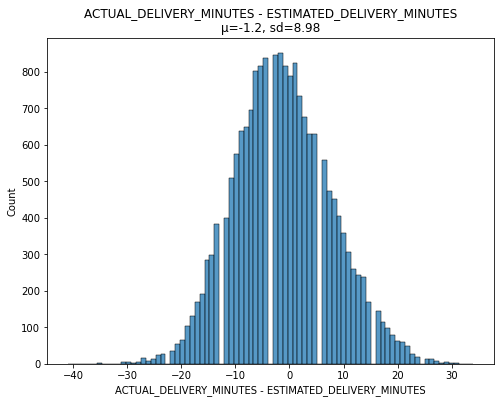

In [3]:
column = 'ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES'
plt.figure(figsize=(8,6))
sns.histplot(order_data[column])
plt.title('{}\nµ={}, sd={}'.format(column, order_data[column].mean().round(2), order_data[column].std().round(2)))
plt.show()

### Data seems to contain information about ordered item quantities, user and venue locations, delivery times and original time estimations, and some weather information.

### With a mean value of -1.21 minutes, the expected value indicates that delivery estimations are slightly optimistic, but overall pretty good. However the distribution has quite a lot of values on the negative side, which means that there are some delivery time estimations that have been exceeded by over 30 minutes. Not nice. Maybe there's something we can do! 

### One from many possible leads: Can we detect when an estimation doesn't hold and the order will arrive late?
#### * This could be used to notify customers in advance for better customer experience.

#### Lets compare few off-the-shelf ML models with few different feature selections.



## First we create few additional columns:

#### The heuristics between creating the following features are:
* Is there a connection between the user–venue distance and false delivery time estimations?
* Or between distance from city centre and false delivery time estimations?
* Do these delays occur specifically at certain hour or at certain day?
* How many orders have arrived during the previous hour?
* Was the delivery late? Let's be less picky and choose a 5-minute threshold for our definiton of something being late.


In [4]:
def get_past_orders(input_df, hours):
    df = input_df.copy()
    start_dates = df['TIMESTAMP'] - pd.Timedelta(hours=hours)
    df['start_index'] = df['TIMESTAMP'].values.searchsorted(start_dates, side='right')
    df['end_index'] = np.arange(len(df))
    df['QTY']=1
    sum_window = lambda row: df['QTY'].iloc[row['start_index']:row['end_index']+1].sum()
    df['rolling_sum'] = df.apply(sum_window, axis=1)
    
    return df['rolling_sum']


In [5]:

order_data = order_data.sort_values(by='TIMESTAMP')

#Simple euclidean distance between venue and user locations
order_data['SHORTEST_DIST'] = (order_data['VENUE_LAT']-order_data['USER_LAT'])**2+(order_data['VENUE_LONG']-order_data['USER_LONG'])**2

#Helsinki (city centre) coords: Latitude: 60.192059, longitude: 24.945831 stored in a tuple
helsinki_coords = (60.192059, 24.945831)

#Simple euclidean distance between city centre and the furthest locations (user or venue).
order_data['LONGEST_DIST_FROM_CENTRE'] = pd.concat([(order_data['USER_LAT']-helsinki_coords[0])**2+(order_data['USER_LONG']-helsinki_coords[1])**2,(order_data['VENUE_LAT']-helsinki_coords[0])**2+(order_data['VENUE_LONG']-helsinki_coords[1])**2], axis=1).max(axis=1)

# Convert from String to datetime
order_data['TIMESTAMP'] = pd.to_datetime(order_data['TIMESTAMP'])

# Hour of event to indicate certain rush hours
order_data['HOUR'] = order_data['TIMESTAMP'].dt.strftime("%H").astype(int)

# Weekday might also give valuable information
order_data['WEEKDAY'] = order_data['TIMESTAMP'].dt.weekday.values

# How many orders has there been within an hour
order_data['PAST_HOUR_ORDERS'] = get_past_orders(order_data, hours=1)

# How many orders has there been within a day
order_data['PAST_DAY_ORDERS'] = get_past_orders(order_data, hours=24)

# Did the order arrive in time (one-hot encoding) 
t=5
order_data['ARRIVED_LATE'] = (order_data['ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES']<-t).astype(int)

### Let's look at the 2 cases: all deliveries and  late deliveries. In both cases the hour data seems to be bimodal, where the peaks are around 8:30 and 15. 

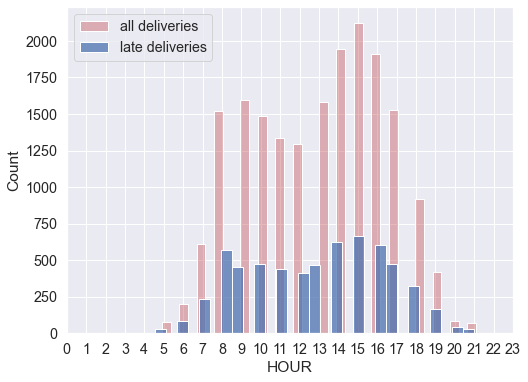

In [6]:
sns.set(font_scale=1.3)
plt.figure(figsize=(8,6))
sns.histplot(order_data['HOUR'], alpha=0.4, color='r', label='all deliveries')
sns.histplot(order_data[order_data['ARRIVED_LATE'].values==1]['HOUR'], bins=30, label='late deliveries')
plt.xticks(range(0,24))
plt.legend()
plt.show()

### Let's next do the same for delivery days. Weekends seem to be busier than rest of the week, except for Wednesday which is close to Friday's order levels.

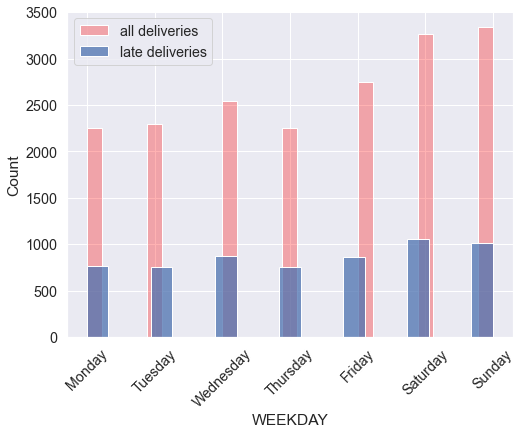

In [7]:
sns.set(font_scale=1.3)
plt.figure(figsize=(8,6))
sns.histplot(order_data['WEEKDAY'], color='red', label='all deliveries', alpha=0.3)
sns.histplot(order_data[order_data['ARRIVED_LATE'].values==1]['WEEKDAY'], label='late deliveries')
plt.xticks(range(7), labels=calendar.day_name[:], rotation=45)
plt.legend()
plt.show()

### How many orders are recieved usually in an hour and in a day? Mean values indicates around 27 orders/hour and 300 orders / day.

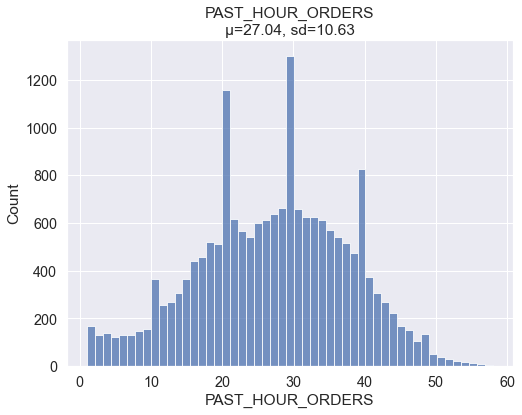

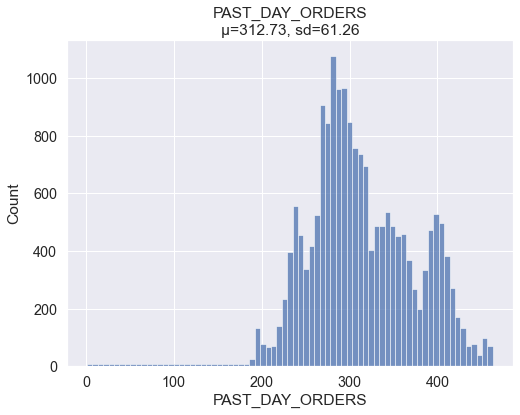

In [8]:
for column in ['PAST_HOUR_ORDERS', 'PAST_DAY_ORDERS']:
    plt.figure(figsize=(8,6))
    sns.histplot(order_data[column])
    plt.title('{}\nµ={}, sd={}'.format(column, order_data[column].mean().round(2), order_data[column].std().round(2)))
    plt.show()

### How many late delivery cases are there in comparison to on time deliveries?

### Roughly one third of the deliveries are late, so our challenge faces a slight imbalance in the dataset (1:2 ratio). Before we do anything else to the dataset let's see how we get by without any distribution manipulations. 

LATE: 6094,
ON TIME: 12612


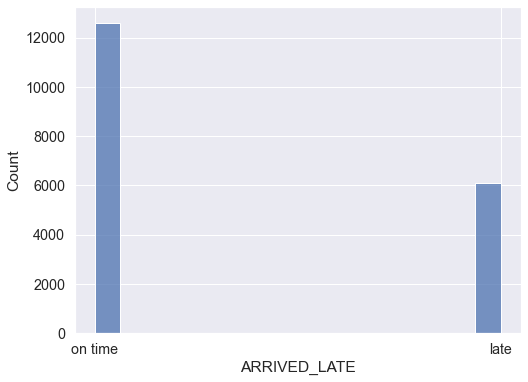

In [9]:
print("LATE: {},\nON TIME: {}".format(order_data['ARRIVED_LATE'].sum(), len(order_data)-order_data['ARRIVED_LATE'].sum()))
plt.figure(figsize=(8,6))
sns.histplot(order_data['ARRIVED_LATE'])
plt.xticks(range(2), labels=['on time', 'late'])
plt.show()



### Next let's draw a heat map to reveal possible trivial correlations.
#### Observations:
* Weather phenomena forms a correlation bubble of its own
* So does location data.
* The features we derived earlier also reveal their origin.
* The derived shortest distance feature correlates with estimated and actual delivery times, but not with their residuals.
* Past hour and day order quantities correlate with weekdays and with wind speed. (Do storms bring more orders in?)

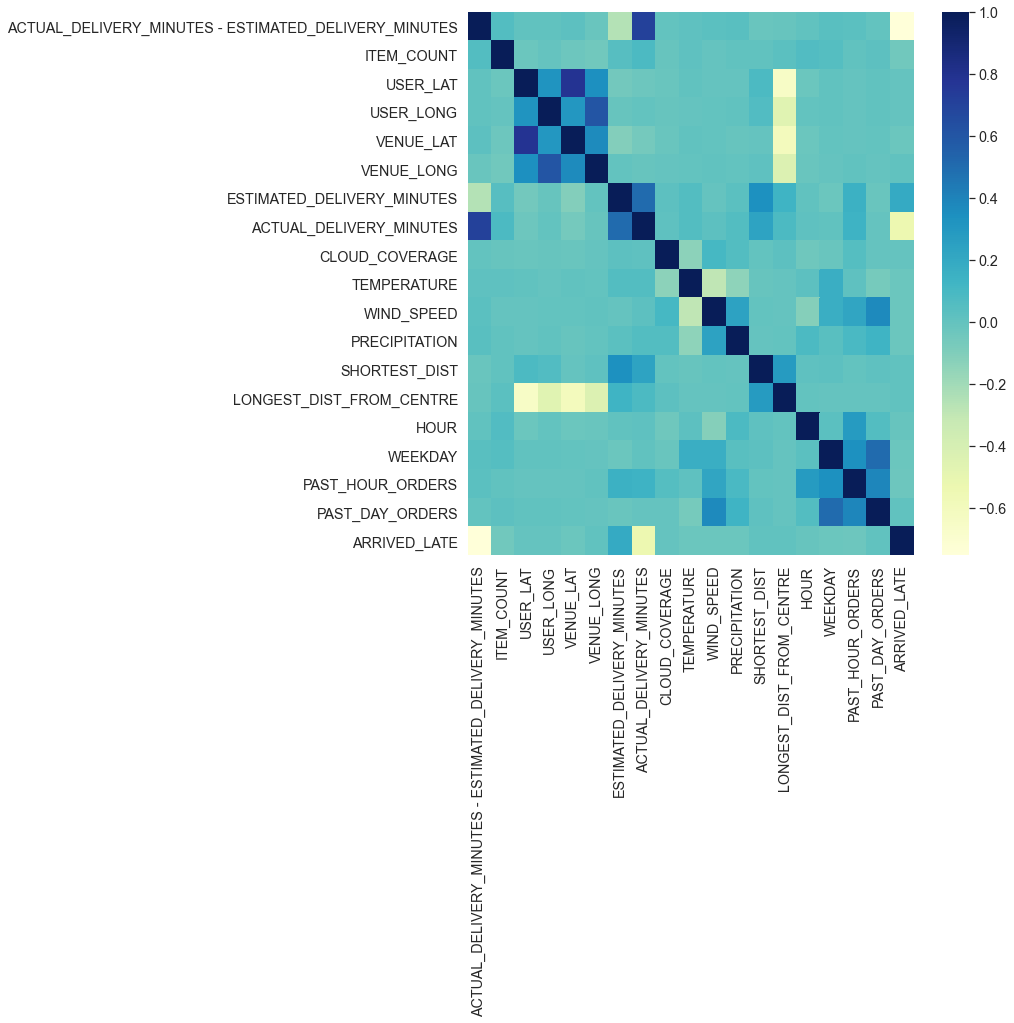

########## 10 most correlated features (by magn.) ##########


,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES
correlation magnitudes,
ESTIMATED_DELIVERY_MINUTES,0.259
ITEM_COUNT,0.060
PRECIPITATION,0.040
WEEKDAY,0.035
PAST_HOUR_ORDERS,0.031
WIND_SPEED,0.028
VENUE_LAT,0.024
TEMPERATURE,0.019
SHORTEST_DIST,0.015


In [10]:

plt.figure(figsize=(10,10))
sns.heatmap(order_data[order_data.columns[1:]].corr(), cmap='YlGnBu')
plt.show()

n_features=10
print("#"*10, "{} most correlated features (by magn.)".format(n_features), "#"*10)
# Let's see the 10 most correlated features with the target (3 first columns are excluded since they contain information from target)
display(((order_data[order_data.columns[1:]].corr()[['ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES']]).abs().sort_values(by='ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES')[::-1][3:3+n_features]).round(3).rename_axis('correlation magnitudes'))


### Lets next check for missing data entries.

In [11]:
print(order_data.isna().sum())

# Seems like there are some missing weather data. Next line reveals that they are only from one day.
print("\nMissing data from date(s):\n{}\n".format(np.unique(pd.to_datetime(order_data[order_data.isna().any(axis=1)]['TIMESTAMP']).dt.strftime("%d/%m/%y"))))

# Since we try to associate weather data (among other features) with delivery time errors, we drop that day from our modelling scenario for now. 
order_data = order_data[~order_data.isna().any(axis=1)]

# If there were more cases we could see whether filling missing weather data is feasible or reasonable,
# but for now we choose not to increase the complexity.
print(order_data.isna().sum())


TIMESTAMP                                                 0
ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES      0
ITEM_COUNT                                                0
USER_LAT                                                  0
USER_LONG                                                 0
VENUE_LAT                                                 0
VENUE_LONG                                                0
ESTIMATED_DELIVERY_MINUTES                                0
ACTUAL_DELIVERY_MINUTES                                   0
CLOUD_COVERAGE                                          277
TEMPERATURE                                             277
WIND_SPEED                                              277
PRECIPITATION                                             0
SHORTEST_DIST                                             0
LONGEST_DIST_FROM_CENTRE                                  0
HOUR                                                      0
WEEKDAY                                 

## Modelling 

### Predicting with time series data is easily biased by leaking crucial information from train data to test data (eg. through autocorrelation) with inadequate evaluation. For this reason we do not shuffle the data prior to choosing our test data. Instead we respect the data's temporal structure and choose our validation data and test data from the end, but hold a break between validation and test data. 

### Later we can compare errors achieved with this evaluation to a k-fold cross validation to see their relation.

#### Next we
* define features that are used as an input. We select multiple combinations, but always make sure not to leak information from target variable. ESTIMATED_DELIVERY_MINUTES is a questionable choice since it's already a prediction, so using it makes this a 2-stage model structure.

* devide our data into train, validation and test data. We leave a gap of 5% between validation and test data to get a better understanding about the generalization error.

* define masks to select only late delivery cases from each set

* Next cell defines a collection of predictive ML models that we can try for the problem.

In [12]:
# Let's define a couple of sets for possible features. The last set contains the 10 most correlated features.
feature_sets = [
    ['USER_LAT','USER_LONG','VENUE_LAT','VENUE_LONG','ITEM_COUNT', 'ESTIMATED_DELIVERY_MINUTES', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION'],
    ['USER_LAT','USER_LONG','VENUE_LAT','VENUE_LONG','ITEM_COUNT', 'ESTIMATED_DELIVERY_MINUTES', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION', 'SHORTEST_DIST', 'WEEKDAY'],
    ['USER_LAT','USER_LONG','VENUE_LAT','VENUE_LONG','ITEM_COUNT', 'ESTIMATED_DELIVERY_MINUTES', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION', 'SHORTEST_DIST', 'HOUR', 'WEEKDAY','PAST_HOUR_ORDERS'],
    ['USER_LAT','USER_LONG','VENUE_LAT','VENUE_LONG','ITEM_COUNT', 'ESTIMATED_DELIVERY_MINUTES', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION', 'SHORTEST_DIST', 'LONGEST_DIST_FROM_CENTRE','PAST_HOUR_ORDERS', 'PAST_DAY_ORDERS'],
    ['USER_LAT','USER_LONG','VENUE_LAT','VENUE_LONG','ITEM_COUNT', 'ESTIMATED_DELIVERY_MINUTES', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION', 'WEEKDAY', 'HOUR', 'SHORTEST_DIST', 'LONGEST_DIST_FROM_CENTRE','PAST_HOUR_ORDERS'],
    ['ITEM_COUNT', 'USER_LAT', 'USER_LONG', 'VENUE_LAT', 'VENUE_LONG', 'ESTIMATED_DELIVERY_MINUTES', 'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION', 'SHORTEST_DIST', 'LONGEST_DIST_FROM_CENTRE', 'HOUR', 'WEEKDAY', 'PAST_HOUR_ORDERS', 'PAST_DAY_ORDERS'],
    ['USER_LAT','USER_LONG','VENUE_LAT','VENUE_LONG','ITEM_COUNT', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION', 'WEEKDAY','SHORTEST_DIST', 'LONGEST_DIST_FROM_CENTRE', 'PAST_HOUR_ORDERS'],
    ['ESTIMATED_DELIVERY_MINUTES', 'ITEM_COUNT', 'PRECIPITATION', 'WEEKDAY','PAST_HOUR_ORDERS', 'WIND_SPEED', 'VENUE_LAT', 'TEMPERATURE', 'SHORTEST_DIST','VENUE_LONG']
]

# Define target variable
target = 'ARRIVED_LATE'

# We make the following splits for model training and evaluation
_train_split = round(len(order_data)*0.75)
_validation_split = _train_split+round(len(order_data)*0.1)
_test_split = round(len(order_data)*0.1)


# Next we prioritize code clarity over memory usage :)
# We also leave a gap of .05 percent to our data to reduce overfitting to certain weather or seasonal event conditions
data_train = order_data[:_train_split]
data_valid = order_data[_train_split:_validation_split]
data_test = order_data[-_test_split:]

### Alternatively we could (but we won't!) shuffle the data followingly:
# data_train, data_test = train_test_split(order_data, train_size=0.9, test_size=0.1, random_state=42, shuffle=True)
# data_train, data_valid = train_test_split(data_train, train_size=0.9, test_size=0.1, random_state=42, shuffle=True)

# We create some masks to help limit our results to certain datapoints
mask_train_late, mask_train_on_time = data_train[target]==1, data_train[target]==0
mask_valid_late, mask_valid_on_time = data_valid[target]==1, data_valid[target]==0
mask_test_late, mask_test_on_time = data_test[target]==1, data_test[target]==0



In [13]:
import random

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, plot_precision_recall_curve, precision_recall_curve, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

np.random.seed(1234)
random.seed(1234)

# we could use tpot to optimize the classifier, but for simplicity we stick to off-the-shelf stuff for now
models = {
    "LogReg": make_pipeline(StandardScaler(), LogisticRegression()),
    "RF" : make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=250, random_state=42)),
    "AdaBoost": make_pipeline(StandardScaler(),AdaBoostClassifier(n_estimators=250, random_state=42)),
    "NB" : make_pipeline(StandardScaler(), GaussianNB()),
    "SVM" : make_pipeline(StandardScaler(), SVC(gamma='auto'))    
    }
model_names = list(models.keys())

# we store accuracy separately for late & on time, multiple models and feature selections.
errors = np.zeros([2,len(feature_sets),len(models.keys())])


#Set to True if you want more info about precision and recall
printing=False
plotting=False


### Lets then try different feature selections with different model types and store accuracy rates separately for late and on time deliveries. 

In [14]:
for i_feature_set, feature_set in enumerate(feature_sets):
    print("evaluating with {}. feature set...".format(i_feature_set+1))
    if plotting:
        fig, ax = plt.subplots(figsize=(8,8))
    for i_model_name, model_name in enumerate(model_names):
        model = models[model_name]
        model.fit(data_train[feature_set], data_train[target])        
        predictions = model.predict(data_valid[feature_set])

        if plotting:
            plot_precision_recall_curve(model, data_valid[feature_set], data_valid[target], name=model_name, ax=ax)
        
        errors[0,i_feature_set,i_model_name] = (predictions[mask_valid_late]==data_valid[target][mask_valid_late]).sum()/mask_valid_late.sum()
        errors[1,i_feature_set,i_model_name] = (predictions[mask_valid_on_time]==data_valid[target][mask_valid_on_time]).sum()/mask_valid_on_time.sum()
        if printing:
            print(model_name,"\n*********\n",classification_report(predictions, data_valid[target], target_names=['ON TIME', 'LATE']))
    if plotting:
        plt.legend()
        plt.show()
print("Done")

evaluating with 1. feature set...
evaluating with 2. feature set...
evaluating with 3. feature set...
evaluating with 4. feature set...
evaluating with 5. feature set...
evaluating with 6. feature set...
evaluating with 7. feature set...
evaluating with 8. feature set...
Done


In [15]:
indx_feat_sets=["feat.set {}".format(f) for f,_ in enumerate(feature_sets)]
acc_late_deliveries = pd.DataFrame(errors[0,:,:], columns=model_names, index=indx_feat_sets).rename_axis('Late deliveries')
acc_ontime_deliveries = pd.DataFrame(errors[1,:,:], columns=model_names, index=indx_feat_sets).rename_axis('On time deliveries')

acc_late_deliveries['feat.mean'] = acc_late_deliveries.mean(axis=1).values 
acc_ontime_deliveries['feat.mean'] = acc_ontime_deliveries.mean(axis=1).values

acc_late_deliveries.loc['model mean'] = acc_late_deliveries.mean(axis=0).values
acc_ontime_deliveries.loc['model mean'] = acc_ontime_deliveries.mean(axis=0).values

display(acc_late_deliveries.round(3))
display(acc_ontime_deliveries.round(3))

,LogReg,RF,AdaBoost,NB,SVM,feat.mean
Late deliveries,,,,,,
feat.set 0,0.056,0.105,0.082,0.115,0.026,0.077
feat.set 1,0.047,0.085,0.089,0.125,0.022,0.074
feat.set 2,0.047,0.089,0.063,0.121,0.023,0.069
feat.set 3,0.055,0.088,0.083,0.122,0.026,0.075
feat.set 4,0.049,0.085,0.062,0.122,0.022,0.068
feat.set 5,0.055,0.095,0.096,0.119,0.024,0.078
feat.set 6,0.000,0.033,0.010,0.020,0.000,0.013
feat.set 7,0.056,0.111,0.069,0.118,0.023,0.075
model mean,0.046,0.086,0.069,0.108,0.021,0.066


,LogReg,RF,AdaBoost,NB,SVM,feat.mean
On time deliveries,,,,,,
feat.set 0,0.989,0.944,0.969,0.969,0.997,0.973
feat.set 1,0.993,0.967,0.949,0.951,0.997,0.972
feat.set 2,0.990,0.970,0.976,0.952,0.997,0.977
feat.set 3,0.994,0.969,0.980,0.952,0.997,0.978
feat.set 4,0.990,0.971,0.977,0.951,0.996,0.977
feat.set 5,0.992,0.974,0.967,0.954,0.996,0.976
feat.set 6,1.000,0.974,0.992,0.976,1.000,0.988
feat.set 7,0.991,0.954,0.983,0.952,0.997,0.975
model mean,0.992,0.965,0.974,0.957,0.997,0.977


#### As expected the On time accuracy is high, since that is the dominant class in the data, but all models perform modestly with detecting Late deliveries.

### Validation set indicates that some gain is achieved with feature selection (feature set 0 is the one with only original features). The problem would need more thorough analysis to find out which features work the best.

### OBJECTIVE: Do more model development / try to find ways to increase validation accuracy  ###
### REALITY: TIME IS RUNNING OUT ###

### As we are interested in how well can we recognize the deliveries that were late, lets stop model tuning, feature engineering etc. and see the final accuracy with our test data. Let's choose RF, NB, and AdaBoost as potential models, and feature set 5 – since at least it's not the worst performing set of features overall.


In [16]:
coeffs = []
val_acc, test_acc = [],[]
val_acc_late, test_acc_late = [],[]

feature_set = feature_sets[5]
potential_models=['NB', 'RF', 'AdaBoost']
for i_model_name, model_name in enumerate(potential_models):
    model = models[model_name]
    model.fit(data_train[feature_set], data_train[target])        
    predictions_val = model.predict(data_valid[feature_set])
    
    if i_model_name > 0:
        coeffs.append(model[1].feature_importances_)
    else:
        coeffs.append(model[1].theta_[1])
    model.fit(data_valid[feature_set], data_valid[target])
    predictions_test = model.predict(data_test[feature_set])
    
    val_acc.append((predictions_val==data_valid[target]).sum()/len(data_valid[target]))
    test_acc.append((predictions_test==data_test[target]).sum()/len(data_valid[target]))

    val_acc_late.append((predictions_val[mask_valid_late]==data_valid[target][mask_valid_late]).sum()/len(data_valid[target][mask_valid_late]))
    test_acc_late.append((predictions_test[mask_test_late]==data_test[target][mask_test_late]).sum()/len(data_test[target][mask_test_late]))


,NB,RF,AdaBoost
All deliveries,,,
valid acc,0.64,0.64,0.64
test acc,0.61,0.61,0.62


,NB,RF,AdaBoost
Late deliveries,,,
valid acc,0.12,0.09,0.10
test acc,0.30,0.33,0.36


,Train set,Validation set,Test set
Data amounts,,,
All deliveries,13822,1843,1843
Late deliveries,4226,696,701


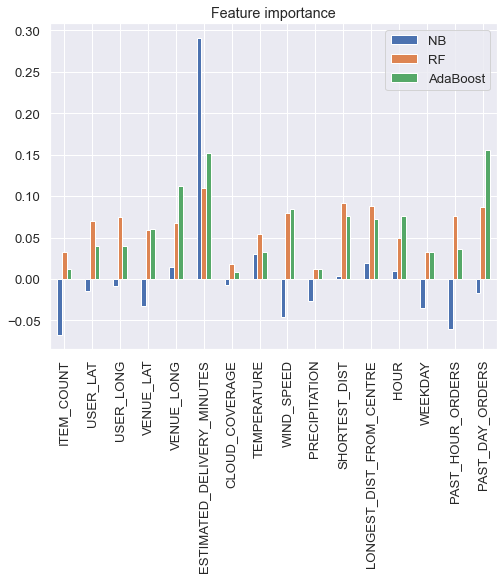

In [17]:
sns.set(font_scale=1.2)
display(pd.DataFrame([val_acc, test_acc], index=['valid acc', 'test acc'], columns=potential_models).rename_axis('All deliveries').round(2))
display(pd.DataFrame([val_acc_late, test_acc_late], index=['valid acc', 'test acc'], columns=potential_models).rename_axis('Late deliveries').round(2))
display(pd.DataFrame([[len(data_train),len(data_valid), len(data_test)], [mask_train_late.sum(),mask_valid_late.sum(), mask_test_late.sum()]], columns=['Train set','Validation set', 'Test set'],index=['All deliveries', 'Late deliveries']).rename_axis('Data amounts').round(2))

model_coefficients = pd.DataFrame(coeffs, columns=feature_set, index=potential_models)

model_coefficients.T.plot(kind='bar', figsize=(8,6))
plt.title("Feature importance")
plt.show()



#### So currently the best performing model AdaBoost seems to detect 36% of the deliveries that are more than 5 minutes late in the validation data, but there is a huge gap between validation and test accuracy, which indicates unstable model behaviour. An interesting observation is also that NaiveBayes relies very heavily on Estimated_delivery_minutes feature. This has the downside that if the original estimation is bad, then....anything derived from it will also be bad. Notably RF and AdaBoost do not have this strong dependency.

#### Final check. What does k-fold CV over all the data say from the performance?

In [18]:
from sklearn.model_selection import KFold

splits=10
kf = KFold(n_splits=splits, shuffle=False)

acc = []
acc_late = []
for model_name in potential_models:
    fold_acc, fold_acc_late = 0,0
    print("Evaluating {}..".format(model_name))
    for train, test in kf.split(order_data):
        mask_late = (order_data.iloc[test][target]==1)
        model = models[model_name]
        model.fit(order_data.iloc[train][feature_set], order_data.iloc[train][target])        
        fold_predictions = model.predict(order_data.iloc[test][feature_set])
        fold_acc += (fold_predictions==order_data.iloc[test][target]).sum()/len(order_data.iloc[test])
        fold_acc_late += (fold_predictions[mask_late]==order_data.iloc[test][target][mask_late]).sum()/mask_late.sum()
    fold_acc/=splits
    fold_acc_late/=splits
    print('Done!')
    
    acc.append(fold_acc)
    acc_late.append(fold_acc_late)

Evaluating NB..
Done!
Evaluating RF..
Done!
Evaluating AdaBoost..
Done!


In [19]:
# a dummy variable that only predicts the most common label
acc_dummy = (data_valid[target].values==np.zeros(len(data_valid))).sum()/len(data_valid)

display(pd.DataFrame([acc+[acc_dummy], acc_late+[0]], index=['all deliveries', 'late deliveries'], columns=potential_models+['Dummy']).rename_axis('Accuracy').round(2))


,NB,RF,AdaBoost,Dummy
Accuracy,,,,
all deliveries,0.67,0.68,0.68,0.62
late deliveries,0.18,0.17,0.20,0.00


### All performances reduced. This might be an implication of overfitting to data's temporal structure (autocorrelation) or to features. With current spec AdaBoost would be the choice for detecting deliveries that are over 5 minutes late. Although the performance rate is still quite poor we did learn something, compared to predicting only the most common label in the data (Dummy model). 

#### Possible next steps:
* Go to literature, find similar problem setups and try to leverage their solutions.
* Balance late delivery class by bootstrapping or creating synthetic data points.
* Run an optimizer such as tpot to find better model structures. 
* Try neural networks or deep learning (My current resources weren't sufficient to experimenting with neural nets. I tried a couple architectures, but didn't work here.)
* Change the threshold from 5 minutes.
* Try regression approach instead to estimate how much the order will be late.

#### The Notebook expanded already to quite a long extent, so no further experiments will be ran.

# Takeaways:

* We developed a predictive model that is capable of notifying customers (with modest accuracy) in advance about possible holdups in their order.
* The model performance isn't great, but at least the performance rate is thoroughly investigated and it's not only giving overly optimistic impressions. This is important when deploying any model into production.

### EXTRA: completely alternative approaches I thought of taking:

#### Where are all the delivery guys and girls?
* Check the density of incoming orders and annotate them by grids.
* Are orders from/to certain area more frequently late?
* Could this be solved with increased number of delivery personnel?
* Does the presense/absense of city centre affect the accuracy of delivery time estimation?

#### Can you blame bad weather? 
* Can weather be used to describe the error in delivery time estimation?
* What about for upcoming orders? Will current weather provide useful information for future delivery times?
* Can we say something about orders 2h ahead?